<a href="https://colab.research.google.com/github/david7franco/DataWarehousing/blob/main/DataPipelineFranco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3 as lite
import csv
%pip install unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
con = lite.connect(
    r"tweets.db"
)  # we'll create a physical database because we're in DW, but for
# 50,000 tweets we could create this in memory. Google it!

cur = con.cursor()



In [ ]:
s = '''&amp; 蔚来汽车有限公司 Automatisiertes System und Verfahren &#39; Primärfrequenz Überwachung &amp; in einen Turbogenerator.&#39;'''

s

'&amp; 蔚来汽车有限公司 Automatisiertes System und Verfahren &#39; Primärfrequenz Überwachung &amp; in einen Turbogenerator.&#39;'

In [ ]:
import html
import unidecode
#get rid of html codes
print(html.unescape(s)+"\n")

#get rid of umlauts in German and convert Chinese to english.
print(unidecode.unidecode(s)+'\n')

import re
#get rid of non-ascii
skips = re.compile(r"[^\x00-\x7F]")  #get rid of anything non-ascii
print(re.sub(skips," ",s)+'\n')

& 蔚来汽车有限公司 Automatisiertes System und Verfahren ' Primärfrequenz Überwachung & in einen Turbogenerator.'

&amp; Wei Lai Qi Che You Xian Gong Si  Automatisiertes System und Verfahren &#39; Primarfrequenz Uberwachung &amp; in einen Turbogenerator.&#39;

&amp;          Automatisiertes System und Verfahren &#39; Prim rfrequenz  berwachung &amp; in einen Turbogenerator.&#39;



In [ ]:
def decode2(s):
    t = unidecode.unidecode(s)
    if (t == '[?]'):
        return '_'
    else:
        return(t)

def decodeStr(s):
    t =""
    for x in s:
      t = t+decode2(x)
    return t


def clean_work(s):
    s = html.unescape(s)
    s = decodeStr(s)  #convert foreign language to bad-english
    skips = re.compile(r"[^\x00-\x7F]")  #get rid of anything non-ascii
    s = re.sub(skips," ",s)
    s = re.sub('  ',' ',s)
    s = s.replace('\t',' ')
    s = s.replace('\n',' ')
    s = s.replace("'"," ")  #get rid of single quotes
    s = s.replace('"',' ')  #get rid of double quotes
    s = s.replace('  ',' ') #get rid of extra spaces
    return(s.strip())

def clean(s):
    s=clean_work(s)
    t=clean_work(s)
    while(s!=t):
        s=t
        t=clean_work(s)
    return(s)


In [ ]:
s

'&amp; 蔚来汽车有限公司 Automatisiertes System und Verfahren &#39; Primärfrequenz Überwachung &amp; in einen Turbogenerator.&#39;'

In [ ]:
clean(s)

'& Wei Lai Qi Che You Xian Gong Si Automatisiertes System und Verfahren Primarfrequenz Uberwachung & in einen Turbogenerator.'

In [ ]:
with open(r"../content/randomTweets.txt") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    for i,row in enumerate(csv_reader):
        if (i < 10):
            date = row[0]
            tweetID = row[1]
            tweet = clean(row[2]).lower()
            handle = row[4]
            print(date,tweetID,tweet,handle,'\n')

print(i,' rows in file')

Sat Jul 25 04:43:04 +0000 2020 1286884650187718656 rt @platinumjab: shiv is the seed of the seed of the seed. shiv is the first seed. shiv is the beginning of the beginning of the beginnin Vijaykant087 

Sat Jul 25 04:43:04 +0000 2020 1286884650175074304 rt @catvalente: every millennial i know is locked in their house doomscrolling & baking bread while their parents think masks are poisonous AndaliteBandit 

Sat Jul 25 05:06:28 +0000 2020 1286890539359416321 rt @ghettofabulos0: candy - partynextdoor x nipsey hussle. thats the tweet. reignofmaya 

Sat Jul 25 05:06:28 +0000 2020 1286890539355459586 rt @realjameswoods: #ripbernelltremmell // this hate crime isnt getting much attention from the democrat propaganda machine, but im hopin BrojackNorseman 

Sat Jul 25 05:06:28 +0000 2020 1286890539330211840 rt @iunarmins: do you see the problem https://t.co/8jgulntrnf Franwfilter 

Sat Jul 25 05:06:28 +0000 2020 1286890539326099456 rt @cloydrivers: dr. fauci, the man who insists we must wear m

In [ ]:
#python string slicing is confusing.
#we'll write simpler functions so future readers can figure out what we're doing
def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

s = 'this is a test'
print(s,'\n',left(s,4),'\n',right(s,4))

this is a test 
 this 
 test


In [ ]:
#return True on retweet
#assumes tweet is lowercase
def isRetweet(tweet):
    return (left(tweet,3)=='rt ')

In [ ]:
import sqlite3 as lite


#create a tweets table
cur.execute('drop table if exists tweets')
cur.execute('create Table tweets(date1 TEXT, tweetID TEXT, TWEET TEXT, handle TEXT, isRetweet INT)')

with open(r"../content/randomTweets.txt") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    for i,row in enumerate(csv_reader):
            date = row[0]
            tweetID = row[1]
            tweet = clean(row[2]).lower()
            handle = row[4]
            if (isRetweet(tweet)):
                isRT = 1
            else:
                isRT = 0
            if ((i % 20000)==0):
                con.commit()
                print('committing row '+str(i))
            try:
              cur.execute("INSERT INTO tweets VALUES (?,?,?,?,?)",
                          (date,tweetID,tweet,handle,isRT))
            except lite.OperationalError as err:
                 print("insert error: %s", err)
                 break


print(i,' rows in file')

committing row 0
committing row 20000
committing row 40000
50025  rows in file


In [ ]:
#simple query to return first 25 tweets in the tweet database

s = "select * from tweets limit 25"
cur.execute(s)
rows = cur.fetchall()

names = list(map(lambda x: x[0], cur.description)) #pulled from stackoverflow, returns the column names - https://stackoverflow.com/questions/7831371/is-there-a-way-to-get-a-list-of-column-names-in-sqlite
print(names)
for row in rows:
    print(row, "\n")


['date1', 'tweetID', 'TWEET', 'handle', 'isRetweet']
('Sat Jul 25 04:43:04 +0000 2020', '1286884650187718656', 'rt @platinumjab: shiv is the seed of the seed of the seed. shiv is the first seed. shiv is the beginning of the beginning of the beginnin', 'Vijaykant087', 1) 

('Sat Jul 25 04:43:04 +0000 2020', '1286884650175074304', 'rt @catvalente: every millennial i know is locked in their house doomscrolling & baking bread while their parents think masks are poisonous', 'AndaliteBandit', 1) 

('Sat Jul 25 05:06:28 +0000 2020', '1286890539359416321', 'rt @ghettofabulos0: candy - partynextdoor x nipsey hussle. thats the tweet.', 'reignofmaya', 1) 

('Sat Jul 25 05:06:28 +0000 2020', '1286890539355459586', 'rt @realjameswoods: #ripbernelltremmell // this hate crime isnt getting much attention from the democrat propaganda machine, but im hopin', 'BrojackNorseman', 1) 

('Sat Jul 25 05:06:28 +0000 2020', '1286890539330211840', 'rt @iunarmins: do you see the problem https://t.co/8jgulntrnf', 

In [ ]:
s = 'select count(tweetID) as cnt1, handle from tweets group by handle order by cnt1 DESC limit 20'
cur.execute(s)
rows = cur.fetchall()
for row in rows:
    print(row)


(16, 'VenkatDhfm00')
(14, 'JackyJane19')
(12, 'A_Kh_5')
(11, 'gaming_stitcher')
(11, 'dhfmbeats3')
(10, 'Khaleja11117')
(10, 'KeshavV78785770')
(9, 'Nenu_offcl')
(8, 'bmurphypointman')
(8, 'EtherealDrill')
(7, 'dhfm_ka')
(7, 'boingolet')
(7, 'Ra_Anila')
(7, 'MBFan24818048')
(7, 'Kaushal25091986')
(7, 'Andreros90')
(6, 'the_reddimalla')
(6, 'ssmb__2')
(6, 'Pranavak7')
(6, 'Nikhil00112410')


In [ ]:
# Format the dates column YYYY-MM-DD HH:MM:SS. You may do this prior to loading the dates in a SQL Database. Please submit a screenshot of the correctly formatted dates

from datetime import datetime

formatted_date ="SELECT date1 as 'Date', * FROM tweets LIMIT 5"
cur.execute(formatted_date)
rows = cur.fetchall()

# function to format TEXT to datetime in sqllite
def format_date(date_string):
    tweet_date = datetime.strptime(date_string, "%a %b %d %H:%M:%S +0000 %Y")
    return tweet_date.strftime('%Y-%m-%d %H:%M:%S')

# Print the results with formatted dates
for row in rows:
    formatted_date = format_date(row[0])
    print(formatted_date, *row[2:]) # taken from stack overflow



2020-07-25 04:43:04 1286884650187718656 rt @platinumjab: shiv is the seed of the seed of the seed. shiv is the first seed. shiv is the beginning of the beginning of the beginnin Vijaykant087 1
2020-07-25 04:43:04 1286884650175074304 rt @catvalente: every millennial i know is locked in their house doomscrolling & baking bread while their parents think masks are poisonous AndaliteBandit 1
2020-07-25 05:06:28 1286890539359416321 rt @ghettofabulos0: candy - partynextdoor x nipsey hussle. thats the tweet. reignofmaya 1
2020-07-25 05:06:28 1286890539355459586 rt @realjameswoods: #ripbernelltremmell // this hate crime isnt getting much attention from the democrat propaganda machine, but im hopin BrojackNorseman 1
2020-07-25 05:06:28 1286890539330211840 rt @iunarmins: do you see the problem https://t.co/8jgulntrnf Franwfilter 1


In [ ]:
#Get Tweets	Get the count of tweets from between July 25 2020 20:00:00 and July 26 2020 20:00:00.
#There were 300092 tweets between those dates!

countOftweets = '''
    SELECT COUNT(*) AS 'Count'
    FROM tweets
    WHERE date1 >= 'Sat Jul 25 20:00:00' AND date1 < 'Sun Jul 26 20:00:00 20:00:00'
'''

cur.execute(countOftweets)

rows = cur.fetchone()

columNames = list(map(lambda x: x[0], cur.description)) # this returns the column names

print(columNames)

for row in rows:
    print(row)



['Count']
30092


In [ ]:
#function to return hashtags
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

In [ ]:
#How many unique hashtags are in the tweets? You do not need to use SQL for this portion of the Homework
q = """ select tweet
        from tweets """
cur.execute(q)

rows = cur.fetchall()

# Extract unique hashtags from the tweets
hashtagList = [row[0] for row in rows]

#put the hashtags in a set
unique_hashtags = set()

#iterate through the hashtagList
for row in hashtagList:
    h = extract_hashtags(row)
    unique_hashtags.update(h)

#print out a list of the unique hashtags
print("Unique Hashtags:", unique_hashtags)

#now print the lengh of the unique hashtags
num_unique_hashtags = len(unique_hashtags)
print("Number of Unique Hashtags:", num_unique_hashtags)





Unique Hashtags: {'scripture', 'bsf', 'jerusalema', 'procards', 'apologi', 'usmca', 'twitterfiction', 'joytrain', 'khudahaafiztrailer', 'sb19_sejun', 'fazectrl', 'bkdk', 'ho', 'hentai', 'bihar', 'bonfire', '9', 'hikeworcester', 'applypressure', 'iss', 'nfl100', 'sfm', 'twitchaffiliate', '5sosonamas', 'july25th', 'shadowhunterslegacy', 'nascar', 'petramacneary', 'suspenddebt', 'hkdc', 'blindspot', 'yoongi', 'streetar', 'whittakertill', 'cardiology', 'leaflygrows', 'flattenthefear', 'hailtothech', 'lawsch', 'delusional', 'jadineformyxawards', 'seaside', 'cmnow', 'seehofer', 'firegase', 'servicecheck', 'saudiarabia', 'aguadilla', 'advancehbdpawakalyan', 'psychobutitsokayep11', 'applefitness', 'ihavejoke', 'fit', 'bookblogger', 'bidenforfl', 'mtvhotte', 'changmin', 'agustd', 'valorant', 'truemaster', 'russian', 'aflcrowsdons', 'bb22allstars', 'bakugo', 'siddhartha', 'ccna', 'pinargultekin', 'ncri', 'str', 'loveonthespectrum', 'max', 'happ', 'therampage', 'hozier', 'nevada', 'thefalconandth

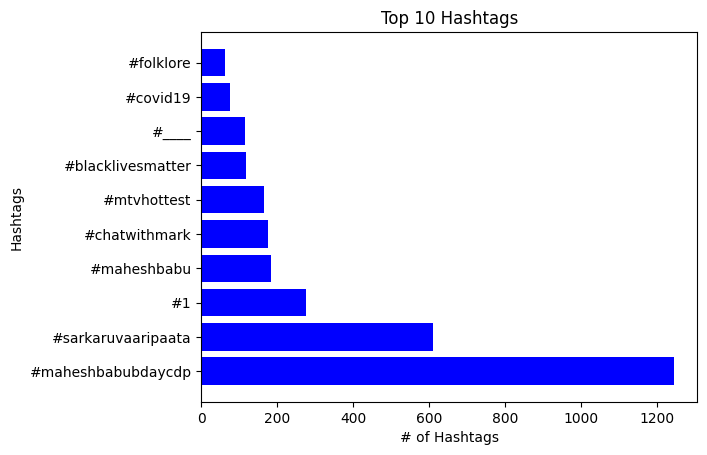

In [ ]:

import matplotlib.pyplot as plt

from collections import Counter

s = """
    SELECT tweet
    FROM tweets
    WHERE INSTR(tweet, '#') > 0;
"""
cursor = cur.execute(s)
tweets_data = cursor.fetchall()


# find all hashtags the database
all_tweets_text = ' '.join(result[0] for result in tweets_data)
numOfHashtags = re.findall(r'#\w+', all_tweets_text)

# use Counter() to count how many hashtags per the hashtags var
hashtags_counter = Counter(numOfHashtags)

top_hashtags, counts = zip(*hashtags_counter.most_common(10))

plt.barh(top_hashtags, counts, color='blue')
plt.xlabel('# of Hashtags')
plt.ylabel('Hashtags')
plt.title('Top 10 Hashtags')
plt.show()



In [ ]:
cur.close()
con.close()